In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as la

In [2]:
def generate_data(rho, n, p_e):
    """
    arguments : 
        - rho   : proba that the sign is flipped
        - n     : number of nodes
        - p_e   : proba of an edge 
    returns   : 
        - s    : vector of size n containing the labels 
        - y    : n x n symmetric matrix with 0 diagonal
        - edges: n x n matrix encoding the edges
    """
    np.random.seed(10) # important for all .py doc ?????? Or one in each function?? 

    S = np.random.choice([1., -1.], size=(n))

    E = np.random.choice([1.,0.],size =((n,n)), p=[p_e,1-p_e]) 
    E = np.triu(E,0) 
    np.fill_diagonal(E,0) # these these last two lines ensure that only the values over the diagonal are non null
    E = E + E.T #ensures that the matrix is symmetric

    Y = np.zeros((n, n)) # Builds (n,n) matrix filled with zeros
    
    for i in range(n):
        for j in range(n):
            if((i != j) and (E[i][j]!= 0) ):
                Y[i][j] = np.random.choice([S[i]*S[j],-S[i]*S[j]],  p=[1-rho,rho])
                Y[j][i] = Y[i][j] # ensures that the matrix is symmetric
    
    return S, Y, E

In [3]:
def run_pca(y):
    """
    arguments : 
        - y : n x n matrix
    returns   : 
        - eigenvector corresponding to the highest eigenvalue of y
    """
    eval, evec = la.eigh(y)
    
    index = np.argmax(eval)

    return evec[:,index]

In [4]:
def log_ratio_posterior(s, i, y, rho, edges):
    """
    arguments : 
        - s     : vector containing the labels
        - i     : index such that s[i] is flipped
        - y     : n x n matrix
        - rho   : flip probability
        - edges : matrix encoding the edges in the graph
    returns   : 
        - log( P(s' | Y) / P(s | Y) ) where s' is the vector defined as s'[i] = -s[i] and s[j] = s[j] for j != i 
    """
    #code explained in pdf file
    
    aux = np.dot(s[i]*s,y[i,:])

    log = aux*(-np.log(1-rho) + np.log(rho))
    return log  

In [5]:
def run_mcmc_fake(y, T, rho, edges):
    """
    arguments : 
        - y   : n x n matrix
        - T   : number of iterations for mcmc
        - rho : flip probability
        - edges : matrix encoding the edges in the graph
    returns   : 
        - list of length T containing the mcmc iterates
    """

    n = np.shape(y)[0]

    S = []
     
    # 1) At t = 1, sample  ⃗s1 from P (⃗s).
    s = np.random.choice([1., -1.], size=(n))
    print(s)
    s_copy = s
    
    for t in range(0,T):
        
        S.append(s_copy)
        s_copy = np.copy(s)

        # 2) At each iteration t, pick an index i uniformly in [1, n]
        i =  np.random.randint(low=0, high=n) # the way the other indices are defined, it is easier to do [0,n-1]
        eta = np.exp(log_ratio_posterior(s_copy, i, y, rho, edges)) #exponential of log_ratio_posterior
        
        if (eta > 1): #higher probability flip index!
            s_copy[i] = -s_copy[i]
        else: # flip with probabilty eta !
            aux = np.random.choice([-1.,1.],size = 1, p=[eta,1-eta])
            s_copy[i] = aux*s_copy[i]

    return S

In [6]:
def run_mcmc(y, T, rho, edges):
    """
    arguments : 
        - y   : n x n matrix
        - T   : number of iterations for mcmc
        - rho : flip probability
        - edges : matrix encoding the edges in the graph
    returns   : 
        - list of length T containing the mcmc iterates
    """

    n = np.shape(y)[0]
    
    # 1) At t = 1, sample  ⃗s1 from P (⃗s).

    s = np.random.choice([1., -1.], size=n) #defining first s
 
    S = np.zeros((T,n)) #create array where s will be stored 
    
    S[0] = np.copy(s)

    for t in range (T-1):
        
        # 2) At each iteration t, pick an index i uniformly in [1, n]
        i =  np.random.randint(low=0, high=n) # the way the other indices are defined, it is easier to do [0,n-1]
        eta = np.exp(log_ratio_posterior(S[t], i, y, rho, edges)) #exponential of log_ratio_posterior
        
        prob=1 

        if eta < 1:
            prob = eta # flip with probabilty eta !

        flip = np.random.choice([1, 0], 1,p=[prob,1-prob])
        
        S[t+1]=S[t]

        if flip == 1:
            S[t+1][i] = -S[t][i]
            
    
    return S

In [7]:
def question_5():
    """
    Here goes the code for question 5 : plot the mixing time and overlap of the MCMC
    """
    # Take n ⩾ 500, pe = 4/n. For ρ ∈ [0.1, 0.4], run Metropolis-Hastings and plot Q(⃗s^t) as a function of time.

    n = 500 # change this value afterwards
    p_e = 4. / n
    step = 0.05
    rho = np.arange(0.1, 0.40+step,step)
    T = 100000

     
    overlaps_rho_final = [] 
  
    for rho_i in rho:
        
        overlaps = []
        overlap_rho = []
        
        S,Y,E = generate_data(rho_i,n,p_e)

        s_star = run_mcmc(Y, T, rho_i, E)

        for i in range(T):
            overlaps.append(np.abs(np.mean(S*s_star[i]))) # (S dim = n, s_star dim =(T,n) ) -> gives me a vector with dimension T !
            if(i > 0.9*T):
                overlap_rho.append(overlaps[-1]) # only gathers values once the system is thermalized

        overlaps_rho_final.append(np.mean(overlap_rho))
        
        # Plot the overlap against the time

        plt.figure(figsize=(8, 8))
        plt.plot(overlaps) 
        plt.xlabel("t")
        plt.ylabel("overlap")
        plt.title(r" $\rho$ = %.2f" % rho_i)
        plt.grid()
        

    # Use these plots to estimate the thermalization time T_therm of Metropolis-Hastings as a function of ρ.

    # A: Thermalization can be seen when energy, for instance is stationary
    # A: Looking at the plots, the thermalization time T_therm depends on ρ! 
     
    # Additionally, plot Q(⃗s^(BO) ) as a function of ρ ∈ [0.1, 0.4].
    
    plt.figure(figsize=(8, 8))
    plt.plot(rho,overlaps_rho_final)  
    plt.xlabel(r"$\rho $")
    plt.ylabel("overlap")
    plt.grid()
    

    # Relate the behaviour of Q(⃗sBO ) with the behaviour of Ttherm . In particular, do you notice a phase transition for Q(⃗s^(BO) ) at some ρ ?
    # A: Seems to happen at ρ = 0.25 

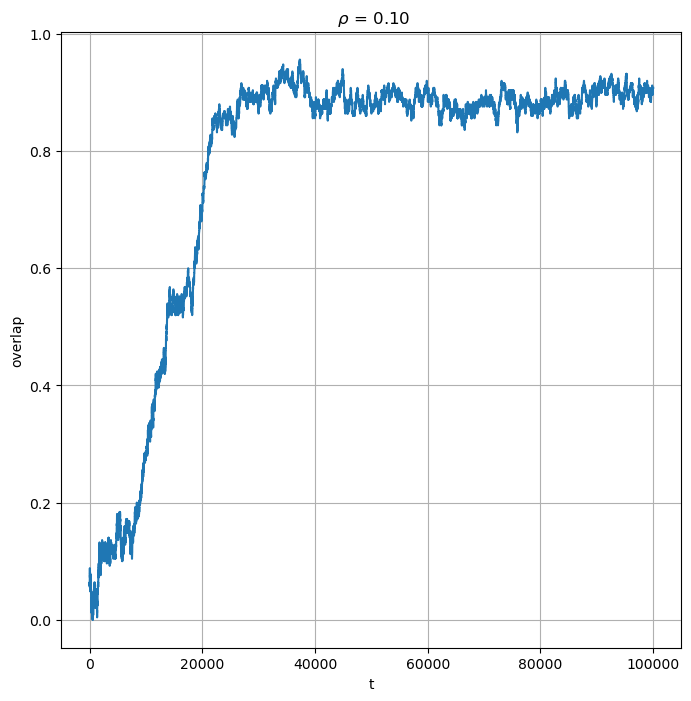

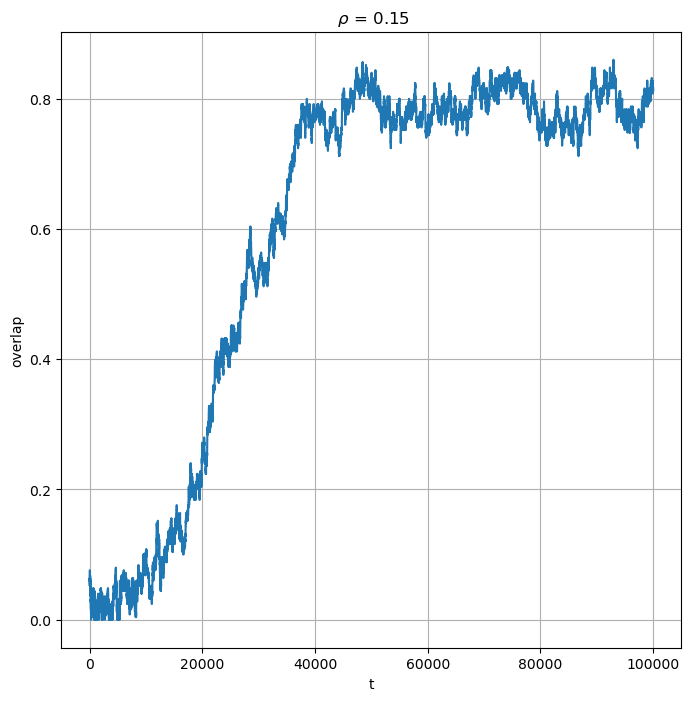

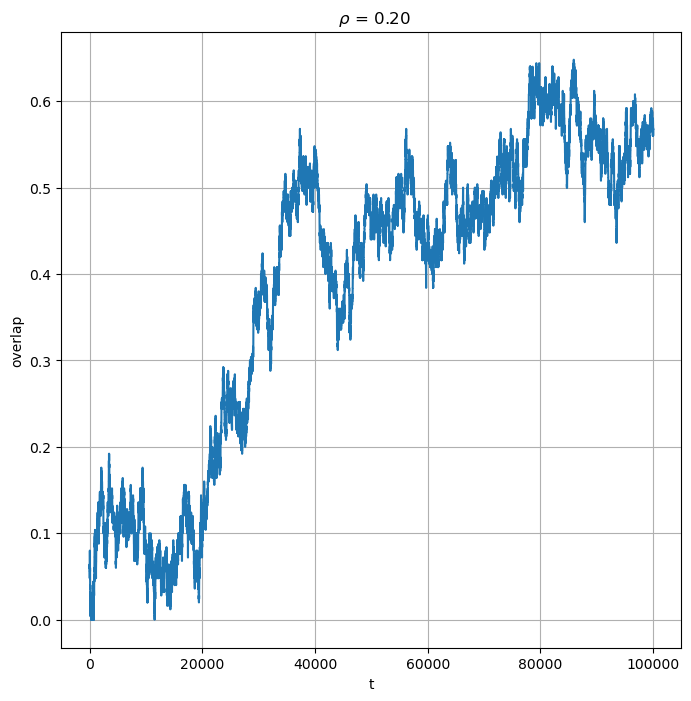

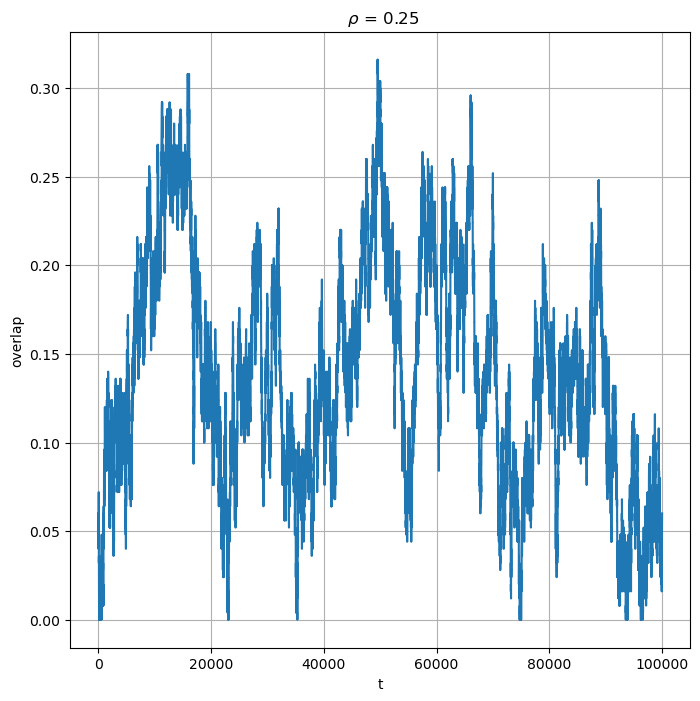

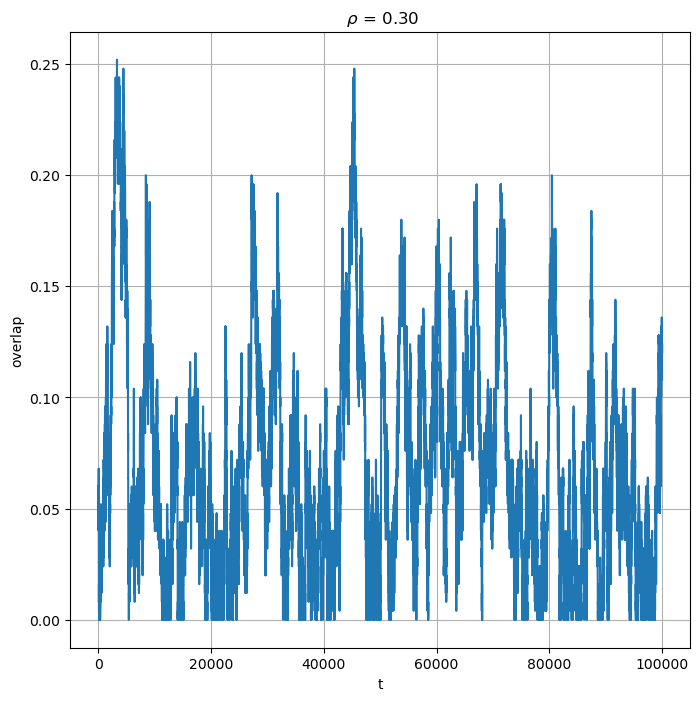

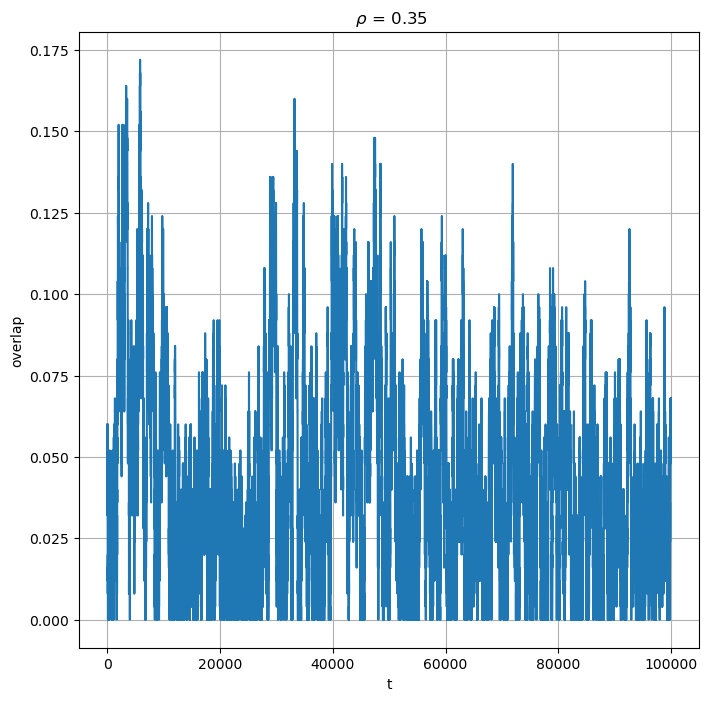

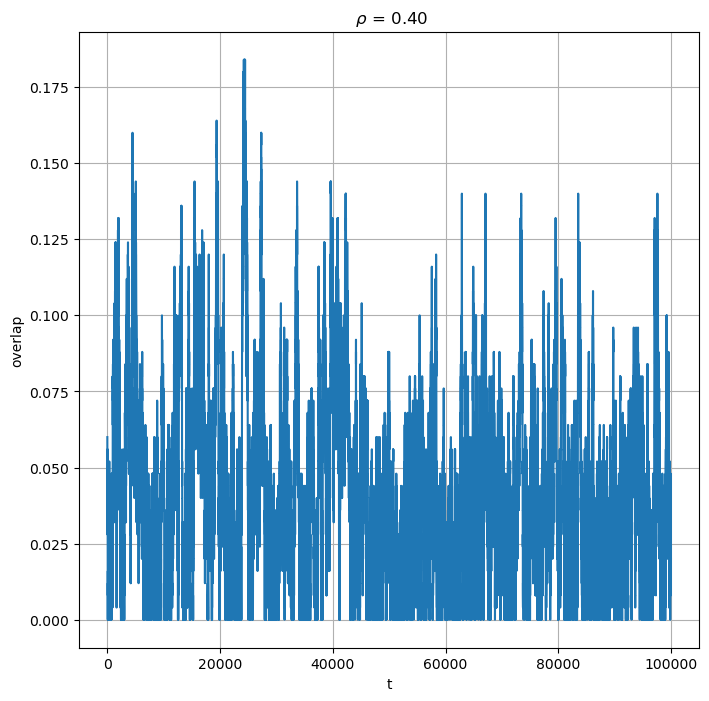

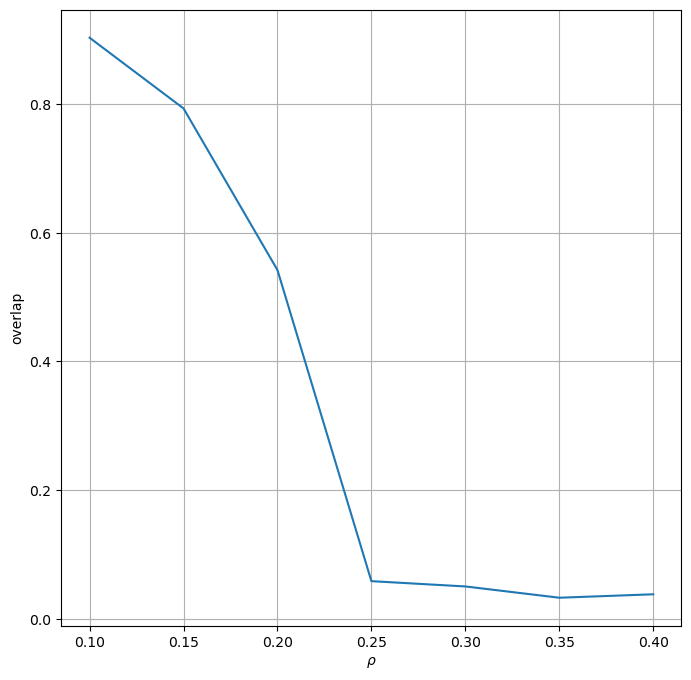

In [25]:
question_5()

## Estimating $T_{therm}$
 How do we know when our markov chain has thermalized? In general there is no good answer to this question, however several heuristics can be used
 

*   Look at when some observables (e.g. energy) are stationary (i.e. their value stops drifting and fluctuates around a constant level)
*   Initialize two independent Markov chains, one with random $s^{(0)}$ independent of $s^*$, and the other at $s^*$. Run the two Markov chains in parallel: $T_{therm}$ is the time at which the observables from the two chains have roughly the same value. This approach has the drawback of requiring the knowledge of $s^*$, which we normally don't have. However in some cases we know the structure of the ordered state (e.g. Ising where $s_i=1 \;\forall i$), so the method can be applied

Let's try this second approach: we run a Monte Carlo initialized from the planted configuration $s^*$ and compare the energy and overlap.


In [10]:
def question_6():
    """
    Here goes the code for question 6 : compare the performance of PCA and BO
    """
    # Take n ⩾ 500, ρ = 0.25. For pe ∈ [2/n, 6/n], compute and plot the overlaps Q(⃗sBO )
    # and Q(⃗sP CA ) as a function of pe . Compare the performance of the two estimators.

    n = 500  
    rho = 0.25
    step = 0.001
    p_e = np.arange(2./n,6./n + step, step)
    T = 100000
    
    
    overlaps_pe = [] 
    overlaps_PCA = []

    
    
    for P_E in p_e:
        
        overlaps = []
        overlap_pe = []
        S,Y,E = generate_data(rho,n,P_E)
        s_star = run_mcmc(Y, T, rho, E)    

        #BO  
        for i in range(T):
            overlaps.append(np.abs(np.mean(S*s_star[i]))) # (S dim = n, s_star dim =(T,n) ) -> gives me a vector with dimension T !
            if(i > 0.9*T):
                overlap_pe.append(overlaps[-1]) # only gathers values once the system is thermalized

        overlaps_pe.append(np.mean(overlap_pe))
        
        
        #PCA
        s_star_pca = run_pca(Y)
        overlaps_PCA.append(np.abs(np.mean(S*s_star_pca)))  
    
       
    
    plt.figure(figsize=(8, 8)) 
    # plot the overlaps Q(⃗sBO ) as a function of pe
    plt.plot(p_e,overlaps_pe,label="Bayes Optimal")
    # plot Q(⃗sP CA ) as a function of pe
    plt.plot(p_e,overlaps_PCA,label="PCA")
    plt.xlabel("$p_e$")
    plt.ylabel("overlap")
    plt.legend()
    plt.grid()

    #Compare the performance of the two estimators.
    """
    Some comments about this...
    BO costs more computationally, PCA is fairly quick!
    BO however gives us a way higher overlap, meaning that gives us better results!

    Wikipédia says:
    In estimation theory and decision theory, a Bayes estimator or a Bayes action is an estimator
    or decision rule that minimizes the posterior expected value of a loss function (i.e., the
    posterior expected loss). Equivalently, it maximizes the posterior expectation of a utility function.
    An alternative way of formulating an estimator within Bayesian statistics is maximum a posteriori estimation.

    Principal component analysis (PCA) is a popular technique for analyzing large datasets containing a high
    number of dimensions/features per observation, increasing the interpretability of data while preserving
    the maximum amount of information, and enabling the visualization of multidimensional data.
    Formally, PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished
    by linearly transforming the data into a new coordinate system where (most of) the variation in the data can
    be described with fewer dimensions than the initial data.  
    """


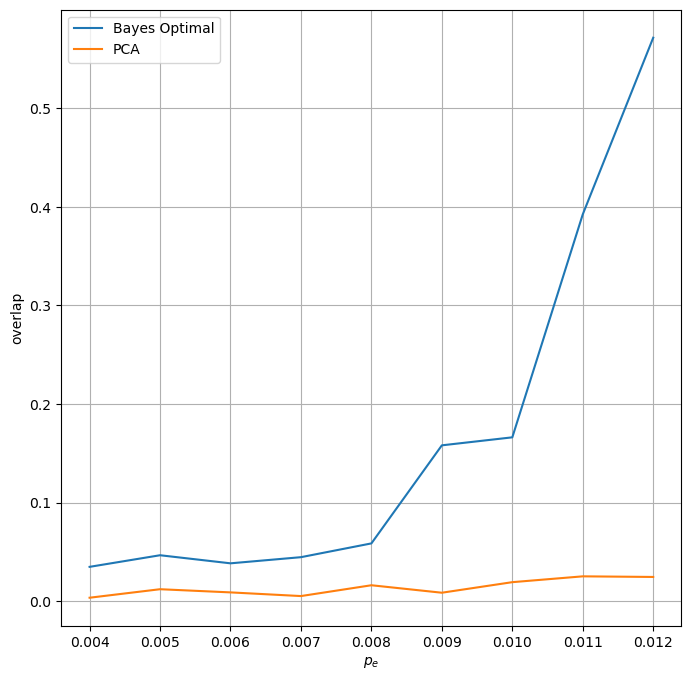

In [11]:
question_6()